## Yelp Dataset: Natural Language Processing

In this NLP project I have attempted to classify Yelp Reviews into 1 star or 5 star categories based off the text content in the reviews.

Dataset: [Yelp Review Data Set from Kaggle](https://www.kaggle.com/c/yelp-recsys-2013).

The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review. The "cool" column is the number of "cool" votes this review received from other Yelp users. All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. In other words, it is a rating of the review itself, not a rating of the business.

The "useful" and "funny" columns are similar to the "cool" column.

**Sohini Mukherjee**

**6.04.2021**

Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from nltk.corpus import stopwords
%matplotlib inline

Getting Data

In [2]:
yelp = pd.read_csv('E:/2.PYTHON-ML-BOOTCAMP/resources/20-Natural-Language-Processing/yelp.csv')

In [3]:
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [4]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [5]:
yelp.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


Creating a new column called "text length" which is the number of words in the text column.

In [6]:
yelp['text length'] = yelp['text'].apply(len)

Exploratory Data Analysis

Creating a grid of 5 histograms of text length based off of the star ratings.

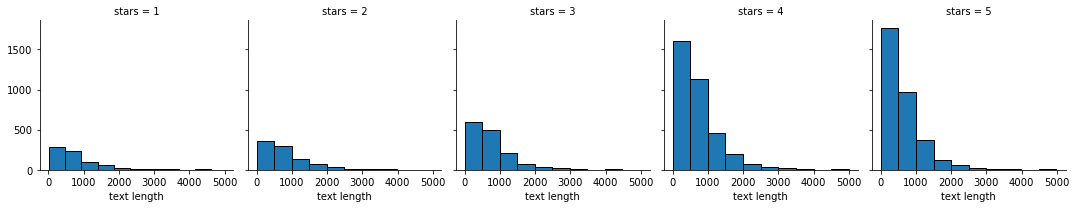

In [8]:
g = sns.FacetGrid(data = yelp, col= 'stars')
g.map(plt.hist, 'text length', ec='black')

Creating a boxplot of text length for each star category.

<AxesSubplot:xlabel='stars', ylabel='text length'>

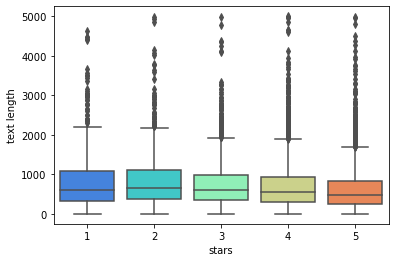

In [11]:
sns.boxplot(x = 'stars', y='text length', data=yelp, palette='rainbow')

Creating a countplot of the number of occurrences for each type of star rating.

<AxesSubplot:xlabel='stars', ylabel='count'>

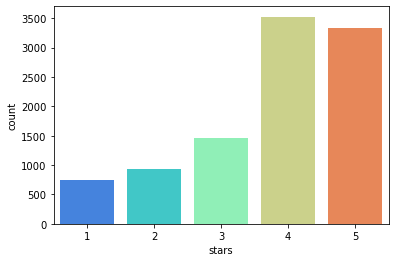

In [12]:
sns.countplot(x='stars', data=yelp, palette='rainbow')

Using groupby to get the mean values of the numerical columns

In [13]:
stars = yelp.groupby('stars').mean()
stars

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


Using the corr() method on that groupby dataframe

In [14]:
stars.corr()

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text length,-0.857664,0.699881,0.843461,1.000000


Then using seaborn to create a heatmap based off that .corr() dataframe

<AxesSubplot:>

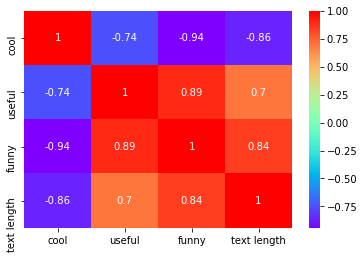

In [16]:
sns.heatmap(data = stars.corr(), annot=True, cmap='rainbow')

## NLP Classification Task

Creating a dataframe called yelp_class that contains the columns of yelp dataframe but for only the 1 or 5 star reviews.

In [17]:
yelp_class = yelp[(yelp.stars==1) | (yelp.stars==5)]

Creating two objects X and y. X will be the 'text' column of yelp_class and y will be the 'stars' column of yelp_class. (features and target/labels)

In [19]:
X = yelp_class['text']
y = yelp_class['stars']

Creating a CountVectorizer object.

In [20]:
cv = CountVectorizer()

Using the fit_transform method on the CountVectorizer object and passing in X (the 'text' column). Saving this result by overwriting X.

In [21]:
X = cv.fit_transform(X)

**Train Test Split**

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

Training a Model

In [24]:
nb = MultinomialNB()

Fitting nb using the training data.

In [26]:
nb.fit(X_train, y_train)

MultinomialNB()

**Predictions and Evaluations**

In [28]:
pred = nb.predict(X_test)

Creating a confusion matrix and classification report using these predictions and y_test 

In [29]:
print(confusion_matrix(y_test, pred))
print('\n')
print(classification_report(y_test, pred))

[[159  69]
 [ 22 976]]


              precision    recall  f1-score   support

           1       0.88      0.70      0.78       228
           5       0.93      0.98      0.96       998

    accuracy                           0.93      1226
   macro avg       0.91      0.84      0.87      1226
weighted avg       0.92      0.93      0.92      1226



Accuracy is 93%.

**Let's see what happens if we try to include TF-IDF to this process using a pipeline.**

In [51]:
pipeline = Pipeline([
    ('bow', CountVectorizer()), #strings to tak token integer counts
    ('tfidf', TfidfTransformer()),  #integer counts to TF-IDF scores
    ('classifier', MultinomialNB()) #train on TF-IDF vectors with naive_bayes classifier
])

**Using the Pipeline**

Redoing the train test split on the yelp_class object.

In [52]:
X = yelp_class['text']
y = yelp_class['stars']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=101)

In [53]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

**Predictions and Evaluation**

In [54]:
preds = pipeline.predict(X_test)

In [55]:
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[  0 228]
 [  0 998]]


              precision    recall  f1-score   support

           1       0.00      0.00      0.00       228
           5       0.81      1.00      0.90       998

    accuracy                           0.81      1226
   macro avg       0.41      0.50      0.45      1226
weighted avg       0.66      0.81      0.73      1226



C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TF-IDF is not improving accuracy to 81%. so let's remove it and check the accuracy of the system

Here I have introduced my own custome analyser to see if it improves the accuracy.

In [56]:
#custom analyser

def text_process(mess):
    
    """
    1. remove punctuation
    2. remove stopwords
    3. return clean text
    """
    
    nopunc = [ char for char in mess if char not in string.punctuation]
    
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [57]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)), #strings to tak token integer counts
      #integer counts to TF-IDF scores
    ('classifier', MultinomialNB()) #train on TF-IDF vectors with naive_bayes classifier
])

X = yelp_class['text']
y = yelp_class['stars']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=101)

pipeline.fit(X_train,y_train)

preds = pipeline.predict(X_test)

print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[143  85]
 [ 11 987]]


              precision    recall  f1-score   support

           1       0.93      0.63      0.75       228
           5       0.92      0.99      0.95       998

    accuracy                           0.92      1226
   macro avg       0.92      0.81      0.85      1226
weighted avg       0.92      0.92      0.92      1226



Accuracy is better without TF-IDF but even the custom analyser is not as good as the default analyser.